# Imports 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import RandAugment
import matplotlib.pyplot as plt
import numpy as np
import random

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)



# CutOut,CutMix and Mixup function definition

In [ ]:
class Cutout(object):
    def __init__(self, n_holes=1, length=16):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        # img: Tensor C x H x W (after ToTensor)
        if not torch.is_tensor(img):
            # defensive: if someone passed PIL, convert won't work here
            raise TypeError("Cutout expects a torch.Tensor (C,H,W) after ToTensor()")

        c, h, w = img.shape
        # create mask with shape (1, h, w) and expand to (c,h,w)
        mask = torch.ones((1, h, w), dtype=img.dtype)

        for _ in range(self.n_holes):
            y = random.randint(0, h - 1)
            x = random.randint(0, w - 1)

            y1 = max(0, y - self.length // 2)
            y2 = min(h, y + self.length // 2)
            x1 = max(0, x - self.length // 2)
            x2 = min(w, x + self.length // 2)

            mask[:, y1:y2, x1:x2] = 0.0

        mask = mask.expand_as(img)
        return img * mask
def mixup_data(x, y, alpha=1.0):
    if alpha <= 0:
        return x, y, 1
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size)
    mixed_x = lam*x + (1-lam)*x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def cutmix_data(x, y, alpha=1.0):
    if alpha <= 0:
        return x, y, 1
    lam = np.random.beta(alpha, alpha)
    batch_size, _, H, W = x.size()
    index = torch.randperm(batch_size)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    w = int(W * np.sqrt(1 - lam))
    h = int(H * np.sqrt(1 - lam))
    x1 = np.clip(cx - w // 2, 0, W)
    y1 = np.clip(cy - h // 2, 0, H)
    x2 = np.clip(cx + w // 2, 0, W)
    y2 = np.clip(cy + h // 2, 0, H)
    x[:, :, y1:y2, x1:x2] = x[index, :, y1:y2, x1:x2]
    lam = 1 - ((x2-x1)*(y2-y1)/(W*H))
    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam

   

# Dataset 

In [12]:
CIFAR10_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR10_STD  = [0.2470, 0.2435, 0.2616]



def get_transforms(use_randaugment=False, use_cutout=False):
    train_tf = [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4)
    ]
    
    if use_randaugment:
        train_tf.append(RandAugment(num_ops=2, magnitude=9))
    
    train_tf.append(transforms.ToTensor())
    
    if use_cutout:
        train_tf.append(Cutout(n_holes=1, length=16))
    
    train_tf.append(transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD))

    # Validation & Test: NO augmentations
    val_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
    ])

    test_tf = val_tf  # identical

    return transforms.Compose(train_tf), val_tf, test_tf


def get_dataloaders(batch_size=128, num_workers=0, use_randaugment=False, use_cutout=False):
    train_tf, val_tf, test_tf = get_transforms(
        use_randaugment=use_randaugment,
        use_cutout=use_cutout
    )

    # Apply train_tf only to train
    full_train_set = datasets.CIFAR10("./data", train=True, download=True, transform=train_tf)

    # Correct split
    train_size = int(0.9 * len(full_train_set))
    val_size = len(full_train_set) - train_size

    train_set, val_indices = random_split(full_train_set, [train_size, val_size])

    # Re-create val_set with val_tf (no augmentations)
    val_set = datasets.CIFAR10("./data", train=True, download=False, transform=val_tf)
    val_set = torch.utils.data.Subset(val_set, val_indices.indices)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader  = DataLoader(datasets.CIFAR10("./data", train=False, download=True, transform=test_tf),
                              batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader


# Baseline CNN

In [13]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SmallCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # 32→16
        )

        # Compute flatten size automatically
        dummy = torch.zeros(1, 3, 32, 32)
        out = self.features(dummy)
        flatten_size = out.numel()

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# Model training

In [15]:
def train_model(
    epochs=30,
    use_randaugment=False,
    use_mixup=False,
    use_cutmix=False,
    use_cutout=False,
    num_workers=0
):
    # -----------------------------------------
    # Dataloaders
    # -----------------------------------------
    train_loader, val_loader, test_loader = get_dataloaders(
        batch_size=128, num_workers=num_workers,
        use_randaugment=use_randaugment,
        use_cutout=use_cutout      # cutout applied inside dataset transform
    )

    # -----------------------------------------
    # Model
    # -----------------------------------------
    model = SmallCNN().to(device)
    optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    scaler = torch.cuda.amp.GradScaler()

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    # -----------------------------------------
    # Training Loop
    # -----------------------------------------
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:

            # -----------------------------------------
            # 🔥 Ensure images & labels go to GPU
            # -----------------------------------------
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # -----------------------------------------
            # MixUp / CutMix
            # -----------------------------------------
            if use_mixup:
                images, targets_a, targets_b, lam = mixup_data(images, labels)
            elif use_cutmix:
                images, targets_a, targets_b, lam = cutmix_data(images, labels)
            else:
                targets_a, targets_b, lam = labels, labels, 1.0

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = (
                    lam * F.cross_entropy(outputs, targets_a)
                    + (1 - lam) * F.cross_entropy(outputs, targets_b)
                )

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item() * images.size(0)
            total += labels.size(0)

            # -----------------------------------------
            # Accuracy (skip if mixup / cutmix)
            # -----------------------------------------
            if not (use_mixup or use_cutmix):
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()

        scheduler.step()

        # Epoch statistics
        train_loss = total_loss / total
        train_acc = 100.0 * correct / total if total > 0 else 0.0
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # -----------------------------------------
        # Validation
        # -----------------------------------------
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                outputs = model(images)
                loss = F.cross_entropy(outputs, labels)
                val_loss += loss.item() * images.size(0)

                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= val_total
        val_acc = 100.0 * val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
            f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%"
        )

    return model, train_losses, train_accs, val_losses, val_accs


Files already downloaded and verified
Files already downloaded and verified

Training Baseline model...
Files already downloaded and verified
Files already downloaded and verified


C:\Users\Acer\AppData\Local\Temp\ipykernel_81160\4010036147.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\Acer\AppData\Local\Temp\ipykernel_81160\4010036147.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/30 | Train Loss: 2.1019 Acc: 22.01% | Val Loss: 1.8609 Acc: 30.94%
Epoch 2/30 | Train Loss: 1.8171 Acc: 32.26% | Val Loss: 1.6103 Acc: 41.12%
Epoch 3/30 | Train Loss: 1.6204 Acc: 40.51% | Val Loss: 1.5438 Acc: 44.42%
Epoch 4/30 | Train Loss: 1.5149 Acc: 45.19% | Val Loss: 1.4474 Acc: 47.94%
Epoch 5/30 | Train Loss: 1.4583 Acc: 48.06% | Val Loss: 1.3619 Acc: 51.76%
Epoch 6/30 | Train Loss: 1.3824 Acc: 50.94% | Val Loss: 1.2724 Acc: 55.58%
Epoch 7/30 | Train Loss: 1.3176 Acc: 53.12% | Val Loss: 1.2360 Acc: 57.20%
Epoch 8/30 | Train Loss: 1.2760 Acc: 55.18% | Val Loss: 1.2370 Acc: 56.66%
Epoch 9/30 | Train Loss: 1.2351 Acc: 56.83% | Val Loss: 1.1467 Acc: 59.22%
Epoch 10/30 | Train Loss: 1.2085 Acc: 57.42% | Val Loss: 1.1636 Acc: 59.82%
Epoch 11/30 | Train Loss: 1.1591 Acc: 59.39% | Val Loss: 1.0519 Acc: 63.14%
Epoch 12/30 | Train Loss: 1.1319 Acc: 60.55% | Val Loss: 1.0631 Acc: 64.30%
Epoch 13/30 | Train Loss: 1.0925 Acc: 61.84% | Val Loss: 1.0130 Acc: 64.96%
Epoch 14/30 | Train L

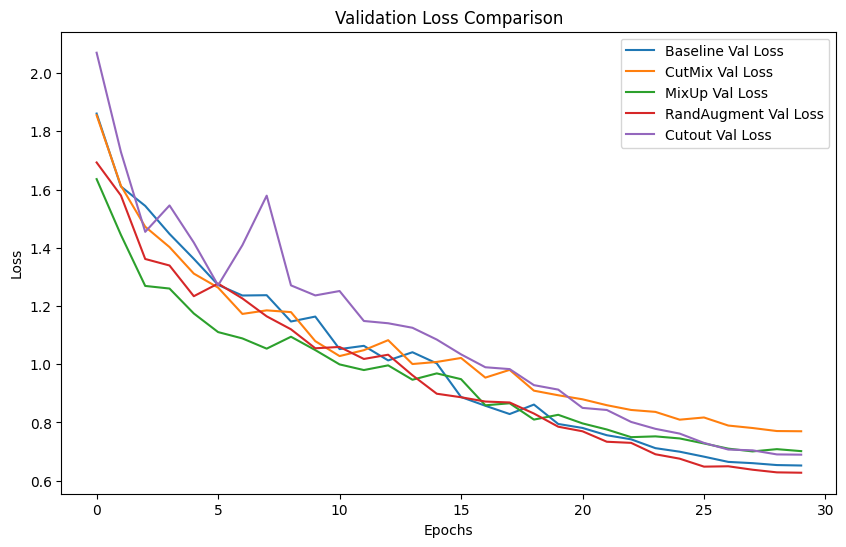

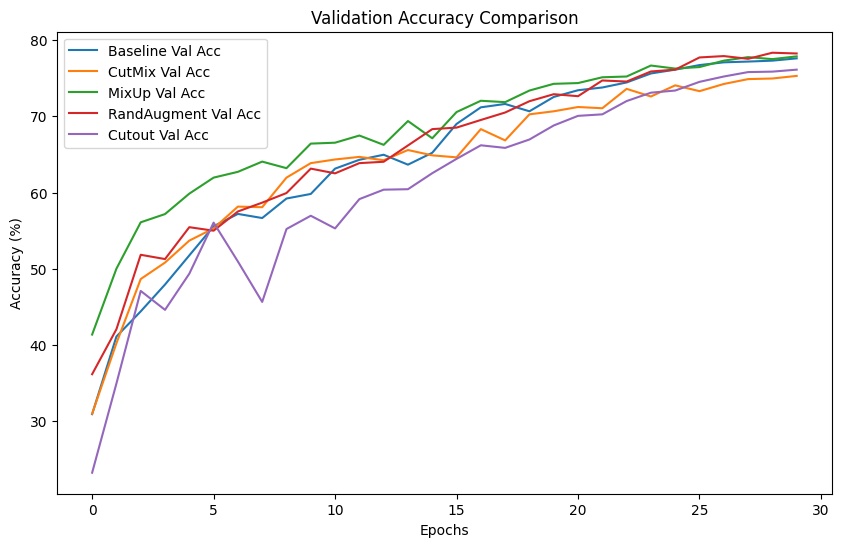


Evaluating Baseline on test set...
Baseline Test Accuracy: 77.59%


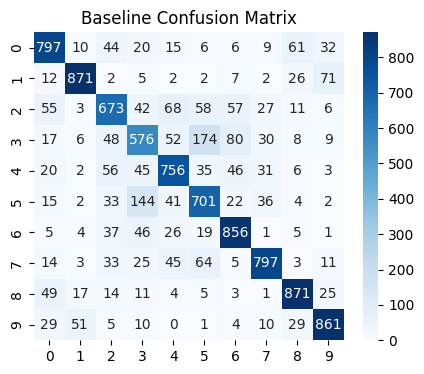

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1000
           1       0.90      0.87      0.88      1000
           2       0.71      0.67      0.69      1000
           3       0.62      0.58      0.60      1000
           4       0.75      0.76      0.75      1000
           5       0.66      0.70      0.68      1000
           6       0.79      0.86      0.82      1000
           7       0.84      0.80      0.82      1000
           8       0.85      0.87      0.86      1000
           9       0.84      0.86      0.85      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000


Evaluating CutMix on test set...
CutMix Test Accuracy: 75.01%


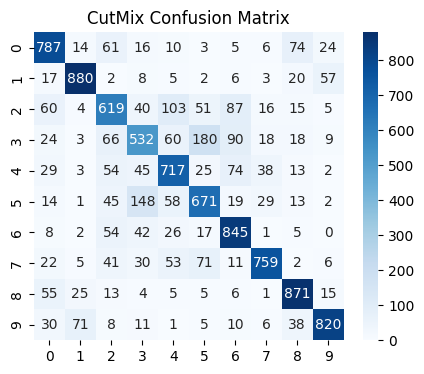

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1000
           1       0.87      0.88      0.88      1000
           2       0.64      0.62      0.63      1000
           3       0.61      0.53      0.57      1000
           4       0.69      0.72      0.70      1000
           5       0.65      0.67      0.66      1000
           6       0.73      0.84      0.78      1000
           7       0.87      0.76      0.81      1000
           8       0.81      0.87      0.84      1000
           9       0.87      0.82      0.85      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000


Evaluating MixUp on test set...
MixUp Test Accuracy: 77.56%


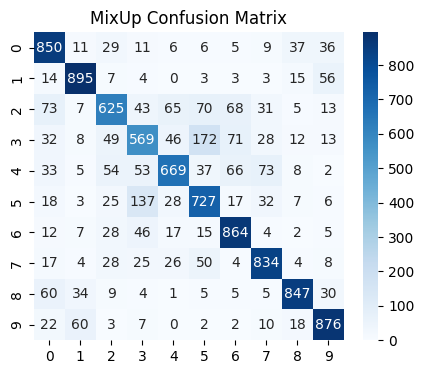

              precision    recall  f1-score   support

           0       0.75      0.85      0.80      1000
           1       0.87      0.90      0.88      1000
           2       0.73      0.62      0.67      1000
           3       0.63      0.57      0.60      1000
           4       0.78      0.67      0.72      1000
           5       0.67      0.73      0.70      1000
           6       0.78      0.86      0.82      1000
           7       0.81      0.83      0.82      1000
           8       0.89      0.85      0.87      1000
           9       0.84      0.88      0.86      1000

    accuracy                           0.78     10000
   macro avg       0.77      0.78      0.77     10000
weighted avg       0.77      0.78      0.77     10000


Evaluating RandAugment on test set...
RandAugment Test Accuracy: 77.74%


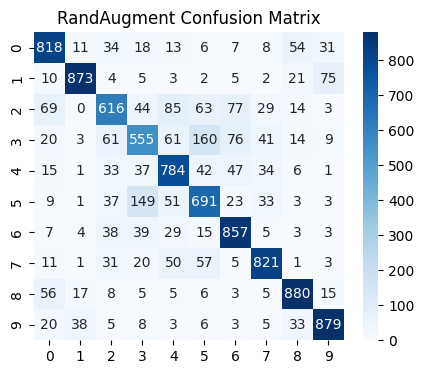

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      1000
           1       0.92      0.87      0.90      1000
           2       0.71      0.62      0.66      1000
           3       0.63      0.56      0.59      1000
           4       0.72      0.78      0.75      1000
           5       0.66      0.69      0.67      1000
           6       0.78      0.86      0.82      1000
           7       0.84      0.82      0.83      1000
           8       0.86      0.88      0.87      1000
           9       0.86      0.88      0.87      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000


Evaluating Cutout on test set...
Cutout Test Accuracy: 74.83%


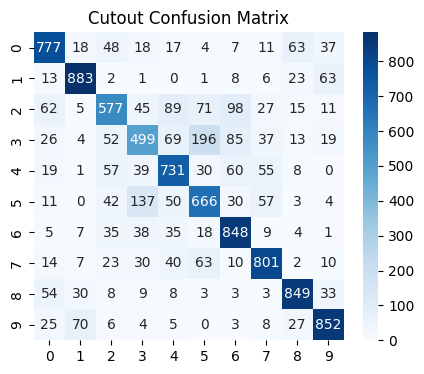

              precision    recall  f1-score   support

           0       0.77      0.78      0.77      1000
           1       0.86      0.88      0.87      1000
           2       0.68      0.58      0.62      1000
           3       0.61      0.50      0.55      1000
           4       0.70      0.73      0.72      1000
           5       0.63      0.67      0.65      1000
           6       0.74      0.85      0.79      1000
           7       0.79      0.80      0.80      1000
           8       0.84      0.85      0.85      1000
           9       0.83      0.85      0.84      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000


Test Accuracy Summary:
Baseline: 77.59%
CutMix: 75.01%
MixUp: 77.56%
RandAugment: 77.74%
Cutout: 74.83%


In [16]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(model, test_loader, device="cuda"):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = sum([p==t for p,t in zip(all_preds, all_labels)]) / len(all_labels)
    return acc, all_labels, all_preds

# -----------------------------
# Train all models
# -----------------------------
histories = {}
models_dict = {}
test_loader = get_dataloaders(batch_size=128)[2]  # get test loader once

# Define configurations
configs = {
    "Baseline": {},
    "CutMix": {"use_cutmix": True},
    "MixUp": {"use_mixup": True},
    "RandAugment": {"use_randaugment": True},
    "Cutout": {"use_cutout": True}
}

for name, cfg in configs.items():
    print(f"\nTraining {name} model...")
    model, tr_loss, tr_acc, val_loss, val_acc = train_model(epochs=30, **cfg)
    
    histories[name] = {
        "train_loss": tr_loss,
        "train_acc": tr_acc,
        "val_loss": val_loss,
        "val_acc": val_acc
    }
    
    models_dict[name] = model

# -----------------------------
# Plot Loss Curves
# -----------------------------
plt.figure(figsize=(10,6))
for name, history in histories.items():
    plt.plot(history["val_loss"], label=f"{name} Val Loss")
plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# -----------------------------
# Plot Accuracy Curves
# -----------------------------
plt.figure(figsize=(10,6))
for name, history in histories.items():
    plt.plot(history["val_acc"], label=f"{name} Val Acc")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

# -----------------------------
# Evaluate Test Metrics
# -----------------------------
test_results = {}
for name, model in models_dict.items():
    print(f"\nEvaluating {name} on test set...")
    acc, y_true, y_pred = evaluate_model(model, test_loader)
    test_results[name] = acc
    print(f"{name} Test Accuracy: {acc*100:.2f}%")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.show()
    
    # Classification Report
    print(classification_report(y_true, y_pred))

# -----------------------------
# Summary Table of Test Accuracies
# -----------------------------
print("\nTest Accuracy Summary:")
for name, acc in test_results.items():
    print(f"{name}: {acc*100:.2f}%")
